In [1]:
import tensorflow as tf
import numpy as np
import os
import random
from skimage.io import imread, imshow
import skimage.transform
import matplotlib.pyplot as plt

In [17]:
source_path = str(r"D:\\Thesis\\Data\\Sen1Floods11\\v1.1\\data\\flood_events\\HandLabeled\\S2Hand")
label_path = str(r"D:\Thesis\Data\Sen1Floods11\v1.1\data\flood_events\HandLabeled\JRCWaterHand")

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
        source.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
        label.append(file)

In [18]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [19]:
X = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(source),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [20]:
for count, file in enumerate(source):
    source_img = imread(source_path +'\\' +file ) #[:,:,IMG_CHANNELS]
    new_image = np.transpose(source_img, (1, 2, 0))
    only_rgb = new_image[:,:,1:4]
    X[count] = only_rgb


for count, file in enumerate(label):
    slabel_img = imread(label_path + '\\'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    Y[count] = y 

The total numnber of Images: 446
The shape of images: (446, 512, 512, 3)


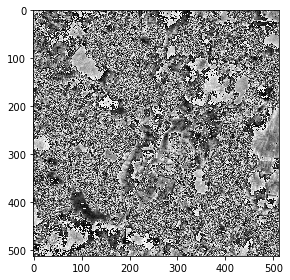

In [22]:
# Sanity Check
print(f"The total numnber of Images: {len(Y)}")
print(f"The shape of images: {X.shape}")

# Sanity Check
rand_idx = random.randrange(X.shape[0])
imshow(X[rand_idx,:,:,0], cmap='gray')
plt.show()



In [23]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 512, 512, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [25]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_flood,h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]

results = model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=10, callbacks=callbacks)

Epoch 1/10
8/8 [==============================] - 191s 23s/step - loss: 6.9676 - mean_io_u_1: 0.4782 - val_loss: 3.0334 - val_mean_io_u_1: 0.4836
Epoch 2/10
8/8 [==============================] - 189s 24s/step - loss: 2.4346 - mean_io_u_1: 0.4846 - val_loss: 1.1438 - val_mean_io_u_1: 0.4835
Epoch 3/10
8/8 [==============================] - 207s 26s/step - loss: 1.3857 - mean_io_u_1: 0.4846 - val_loss: 0.7256 - val_mean_io_u_1: 0.4836
Epoch 4/10
8/8 [==============================] - 195s 25s/step - loss: 0.9734 - mean_io_u_1: 0.4853 - val_loss: 0.5285 - val_mean_io_u_1: 0.4836
Epoch 5/10
8/8 [==============================] - 188s 24s/step - loss: 0.7383 - mean_io_u_1: 0.4853 - val_loss: 0.4000 - val_mean_io_u_1: 0.4836
Epoch 6/10
8/8 [==============================] - 192s 24s/step - loss: 0.5712 - mean_io_u_1: 0.4854 - val_loss: 0.3205 - val_mean_io_u_1: 0.4836
Epoch 7/10
8/8 [==============================] - 196s 25s/step - loss: 0.4490 - mean_io_u_1: 0.4854 - val_loss: 0.2959 - va

In [16]:
#Predict the Test images

preds_test = model.predict(x_test, verbose=1)

5/5 [==============================] - 25s 3s/step


In [18]:
# Each pixel is given a value between 0 and 1. We set a threshold .5 to binarize.
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [19]:
preds_test_t

array([[[[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [0]],

        [[0],
         [1],
         [1],
         ...,
         [1],
         [0],
         [0]],

        [[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],


In [13]:
model.save("U-NET_S2Hand_LabelHand")

INFO:tensorflow:Assets written to: U-NET_S2Hand_LabelHand\assets


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
score = model.evaluate(x_test, y_test, batch_size=32)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100

5/5 [==============================] - 16s 3s/step - loss: 0.2724 - mean_io_u_1: 0.4839


In [27]:
Test_accuracy

48.38756620883942

In [28]:
Test_Loss

27.241936326026917

https://www.tensorflow.org/guide/keras/train_and_evaluate

In [ ]:
tf.keras.metrics.MeanIoU(num_classes=2)

In [ ]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()